In [105]:
#Import Libraries
import pandas as pd
from pandas import json_normalize
import numpy as np
import json 
import ast
import matplotlib.pyplot as plt
np.random.seed(0)

# Import dataset (Suprise! it is a nested json)
customer_file = 'customers.json'
df = pd.read_json(customer_file, lines= True)

In [106]:
##Creating Customer DataFrame:
customers = json_normalize(df['customer'])

In [107]:
## Creating an orders DataFrame:
orders_nested = pd.DataFrame([md for md in df.orders])

orders=[]
for index,row in orders_nested.iterrows():
    for order in row:
        if order != None:
            orders.append(order)           
orders = pd.DataFrame(orders)

In [108]:
## Creating a transactions dataframe:
transactions_nested = pd.DataFrame([md for md in df.transactions])

transactions=[]
for index,row in transactions_nested.iterrows():
    for transaction in row:
        if transaction != None:
            transactions.append(transaction)           
transactions = pd.DataFrame(transactions)

In [109]:
#Creating a payment_methods dataframe:
payment_nested = pd.DataFrame([md for md in df.paymentMethods])

payment_methods=[]
for index,row in payment_nested.iterrows():
    for order in row:
        if order != None:
            payment_methods.append(order)           
payment_methods = pd.DataFrame(payment_methods)


In [110]:
#Merging orders with transactions:
orders_transactions= orders.merge(transactions, on='orderId', how='left')

In [111]:
##Merge orders + transactions and paymentMethods
orders_transactions_payments = orders_transactions.merge(payment_methods, on='paymentMethodId', how='left')

In [112]:
#Remove duplicated columns:
duplicated_columns = ['transactionAmount']
orders_transactions_payments.drop(columns=duplicated_columns,inplace= True)

In [113]:
#Create a copy of the dataframe (as a checkpoint)
df= orders_transactions_payments.copy()

In [114]:
#Is orderAmounts are equal between transactions of the same order:
orderId =set(df['orderId'])
len(orderId)

group_list=[]
for id in orderId:
    group = df[df['orderId'] == id]
    orderAmounts = group['orderAmount']
    if len(set(orderAmounts)) == 1:
        group_list.append(True)
    else:
        group_list.append(False)

all(group_list)

True

In [115]:
#Who has more than one transaction
groups=[]
for id in orderId:
    group = df[df['orderId'] == id]
    
    if len(group) >1:
        groups.append(id)

len(groups)

110

In [13]:
#Is orderShippingAdresses are equal between transactions of the same order:
group_list=[]
for id in orderId:
    group = df[df['orderId'] == id]
    orderAmounts = group['orderShippingAddress']
    if len(set(orderAmounts)) == 1:
        group_list.append(True)
    else:
        group_list.append(False)

all(group_list)

True

In [14]:
#Function for merging transactions to orders. Plenty different features that I created. New features can be added.
def merge_transactions(group):
    #Merge transactions into one order:
    transaction_count = len(group)
    orderAmount = list(group.orderAmount)[0]
    
    fullfilled_order_count=len(group[group['orderState'] == 'fulfilled'])
    pending_order_count =len(group[group['orderState'] == 'pending'])
    failed_order_count =len(group[group['orderState'] == 'failed'])
    
    orderShippingAddress = list(group.orderShippingAddress)[0]
    
    #we dont need transationID
    paymentMethod_count = len(set(group['paymentMethodId']))
    transactionFailed_count =len(group[group['transactionFailed'] == True])
    paymentRegisterFail_count = len(group[group['transactionFailed'] == True])
    paymentMethodProvider_count = len(set(group['paymentMethodProvider']))

    #Bunlar len değil de 0 - 1 olabilir belki
    paymentMethodType_apple =len(group[group['paymentMethodType'] == 'apple pay'])
    paymentMethodType_btc =  len(group[group['paymentMethodType'] == 'bitcoin'])
    paymentMethodType_card =len(group[group['paymentMethodType'] == 'card'])
    paymentMethodType_paypal =len(group[group['paymentMethodType'] == 'paypal'])
    orderId = list(group.orderId)[0]
    
    return [orderId,transaction_count,orderAmount,fullfilled_order_count,
            pending_order_count,failed_order_count,
            orderShippingAddress,paymentMethod_count,
            transactionFailed_count,paymentMethodProvider_count,
            paymentMethodType_apple, paymentMethodType_btc,paymentMethodType_card, paymentMethodType_paypal]


In [15]:
#Merge transactions into order_groups
group_list=[]
for id in orderId:
    group = df[df['orderId'] == id]
    
    row = merge_transactions(group)
    group_list.append(row)

In [16]:
group_list = pd.DataFrame(group_list, columns =['orderId','transaction_count','orderAmount','fullfilled_order_count',
            'pending_order_count','failed_order_count',
            'orderShippingAddress','paymentMethod_count',
            'transactionFailed_count','paymentMethodProvider_count',
            'paymentMethodType_apple', 'paymentMethodType_btc','paymentMethodType_card', 'paymentMethodType_paypal'])

In [21]:
#Now merge orders with customer_df
df = pd.read_json(customer_file, lines= True)
customer_orders={}
for index,row in df.iterrows():
    customer = json_normalize(row['customer'])
    customerEmail =  customer.customerEmail
    try:
        orders = json_normalize(row['orders'])['orderId']
        
        orders_df=group_list[group_list['orderId'].isin(orders)]
        
    except:
        orders = None
    
    if orders  is not None:
        customer_orders[customerEmail[0]] = orders
    else:
        customer_orders[customerEmail[0]] = None

In [22]:
customer_orders = pd.DataFrame.from_dict(customer_orders).T
customer_orders.head()

,0,1,2,3,4,5,6,7
josephhoward@yahoo.com,vjbdvd,yp6x27,NaN,NaN,NaN,NaN,NaN,NaN
evansjeffery@yahoo.com,nlghpa,uw0eeb,bn44oh,NaN,NaN,NaN,NaN,NaN
andersonwilliam@yahoo.com,yk34y2,28v6b0,itnk8y,NaN,NaN,NaN,NaN,NaN
rubenjuarez@yahoo.com,fbz9ep,7odnn6,audx7o,NaN,NaN,NaN,NaN,NaN
uchen@malone.com,56h7iw,kowj1v,wlznfu,hm3rth,vvq05w,xwo0al,2528x8,NaN


In [48]:
order_counts =[]
for index,row in customer_orders.iterrows():
    order_count=0
    for column in row:
        if pd.notna(column):
            order_count += 1
    order_counts.append([index, order_count])
    
order_counts= pd.DataFrame(order_counts, columns=['customerEmail','order_counts'])

order_counts.head()

,customerEmail,order_counts
0,josephhoward@yahoo.com,2
1,evansjeffery@yahoo.com,3
2,andersonwilliam@yahoo.com,3
3,rubenjuarez@yahoo.com,3
4,uchen@malone.com,7


In [49]:
def merge_orders_to_customer(row):

    customer = json_normalize(row['customer'])
    #Customer Features:
    customerEmail =  list(customer.customerEmail)[0]
    customerPhone = list(customer.customerPhone)[0]
    customerDevice = list(customer.customerDevice)[0]
    customerIPAddress = list(customer.customerIPAddress)[0]
    customerBillingAddress = list(customer.customerBillingAddress)[0]
    
    orders =json_normalize(row['orders'])

    if len(orders) !=0:
        orders = orders['orderId']  
        orders_df=group_list[group_list['orderId'].isin(orders)]
        orders_df.head()

        #Order Features:
        order_counts = len(orders_df)
        transaction_counts = orders_df['transaction_count'].sum()
        orderAmount_sum = orders_df['orderAmount'].sum()
        orderAmount_mean = orders_df['orderAmount'].mean()
        fulfilled_order_counts = orders_df['fullfilled_order_count'].sum()
        pending_order_counts = orders_df['pending_order_count'].sum()
        failed_order_counts = orders_df['failed_order_count'].sum()

        shipping_adresses_count = len(set(orders_df['orderShippingAddress']))
        shipping_adress_same =  (customerBillingAddress == list(orders_df['orderShippingAddress'])[0])
        paymentMethod_counts = orders_df['paymentMethod_count'].sum()
        transactionFailed_counts = orders_df['transactionFailed_count'].sum()
        paymentMethodProvider_counts = orders_df['paymentMethodProvider_count'].sum()

        paymentMethodType_apples = orders_df['paymentMethodType_apple'].sum()
        paymentMethodType_btcs = orders_df['paymentMethodType_btc'].sum()
        paymentMethodType_cards = orders_df['paymentMethodType_card'].sum()
        paymentMethodType_paypals = orders_df['paymentMethodType_paypal'].sum()
        
    else:
        #If there is no order:
        order_counts =0
        transaction_counts= 0
        orderAmount_sum= 0
        orderAmount_mean= 0
        fulfilled_order_counts= 0
        pending_order_counts = 0
        failed_order_counts = 0
        shipping_adresses_count = 0
        shipping_adress_same = False
        paymentMethod_counts = 0
        transactionFailed_counts = 0
        paymentMethodProvider_counts = 0
        paymentMethodType_apples = 0
        paymentMethodType_btcs = 0
        paymentMethodType_cards = 0
        paymentMethodType_paypals = 0

    return [customerEmail,customerPhone,
            customerDevice,customerIPAddress,
            order_counts,transaction_counts,orderAmount_sum,
            orderAmount_mean,fulfilled_order_counts,
            pending_order_counts,failed_order_counts,
            shipping_adresses_count,shipping_adress_same,
            paymentMethod_counts,
            paymentMethodProvider_counts, paymentMethodType_apples,
            paymentMethodType_btcs,paymentMethodType_cards,paymentMethodType_paypals
           ]

In [50]:
#Merge orders into customers
customer_list=[]
for index,row in df.iterrows():
    
    customer = merge_orders_to_customer(row)
    customer_list.append(customer)

In [51]:
customer_list = pd.DataFrame(customer_list, columns =['customerEmail','customerPhone',
            'customerDevice','customerIPAddress',
            'order_counts','transaction_counts','orderAmount_sum',
            'orderAmount_mean','fulfilled_order_counts',
            'pending_order_counts','failed_order_counts',
            'shipping_adresses_count','shipping_adress_same',
            'paymentMethod_counts',
            'paymentMethodProvider_counts', 'paymentMethodType_apples',
            'paymentMethodType_btcs','paymentMethodType_cards','paymentMethodType_paypals'
           ])

In [52]:
customer_list['customerEmail'] = [email.split('@')[1] for email in customer_list['customerEmail']]

In [54]:
email_domains= []
mails= []
popular_providers = ['yahoo', 'gmail', 'hotmail']
for email in customer_list['customerEmail']:
    try:
        domain = email.split('.')[1]
        mail = email.split('.')[0]
        
        if mail in popular_providers:
            mails.append(mail)
        else:
            mails.append('other')
        email_domains.append(domain)
        
    except:
        email_domains.append('weird')
        mails.append('weird')
        print(email)

u6n7x
1jcfcxs7
6eph
jedyz63t


In [55]:
customer_list['email_domain'] = email_domains
customer_list['customerEmail'] = mails

In [58]:
IP_addresses = []
for address in customer_list['customerIPAddress']:
    if len(address) > 20:
        IP_addresses.append('digits_and_letters')
    else:
        IP_addresses.append('only_letters')
customer_list['customerIPAddress'] = IP_addresses

In [60]:
customer_list = customer_list.drop(columns=['customerPhone','customerDevice'])

In [65]:
customer_list['fraudulent'] = df['fraudulent']

## Training Part

In [79]:
X = customer_list.drop(columns=['fraudulent'])
y = df['fraudulent']

In [80]:
X.head()

,customerEmail,customerIPAddress,order_counts,transaction_counts,orderAmount_sum,orderAmount_mean,fulfilled_order_counts,pending_order_counts,failed_order_counts,shipping_adresses_count,shipping_adress_same,paymentMethod_counts,paymentMethodProvider_counts,paymentMethodType_apples,paymentMethodType_btcs,paymentMethodType_cards,paymentMethodType_paypals,email_domain
0,yahoo,only_letters,2,2,44,22.000000,1,1,0,1,True,2,2,0,0,2,0,com
1,yahoo,only_letters,3,3,111,37.000000,3,0,0,3,True,3,3,0,3,0,0,com
2,yahoo,digits_and_letters,3,5,82,27.333333,4,0,1,2,True,4,4,0,0,5,0,com
3,yahoo,digits_and_letters,3,3,85,28.333333,3,0,0,2,True,3,3,0,0,3,0,com
4,other,only_letters,7,7,411,58.714286,6,0,1,2,True,7,7,3,0,4,0,com


In [81]:
#Creating categorical data
X['customerEmail'] = X['customerEmail'].astype('category')
X['customerIPAddress'] = X['customerIPAddress'].astype('category')
X['email_domain'] = X['email_domain'].astype('category')

X = pd.get_dummies(X, columns=['customerEmail','customerIPAddress','email_domain'])

In [82]:
X

,order_counts,transaction_counts,orderAmount_sum,orderAmount_mean,fulfilled_order_counts,pending_order_counts,failed_order_counts,shipping_adresses_count,shipping_adress_same,paymentMethod_counts,...,customerEmail_weird,customerEmail_yahoo,customerIPAddress_digits_and_letters,customerIPAddress_only_letters,email_domain_biz,email_domain_com,email_domain_info,email_domain_net,email_domain_org,email_domain_weird
0,2,2,44,22.000000,1,1,0,1,True,2,...,0,1,0,1,0,1,0,0,0,0
1,3,3,111,37.000000,3,0,0,3,True,3,...,0,1,0,1,0,1,0,0,0,0
2,3,5,82,27.333333,4,0,1,2,True,4,...,0,1,1,0,0,1,0,0,0,0
3,3,3,85,28.333333,3,0,0,2,True,3,...,0,1,1,0,0,1,0,0,0,0
4,7,7,411,58.714286,6,0,1,2,True,7,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,3,3,126,42.000000,2,0,1,2,False,3,...,0,0,0,1,0,1,0,0,0,0
164,5,6,135,27.000000,6,0,0,2,True,6,...,0,0,0,1,1,0,0,0,0,0
165,4,4,121,30.250000,4,0,0,3,True,4,...,0,0,1,0,0,1,0,0,0,0
166,6,8,287,47.833333,7,0,1,4,False,8,...,0,0,0,1,0,1,0,0,0,0


In [87]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=customer_list['fraudulent'])

5 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.64414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.603865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.663352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.64277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.653678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.556601
Training until validation scores don't improve for 100 rounds
Early stopping, best iter

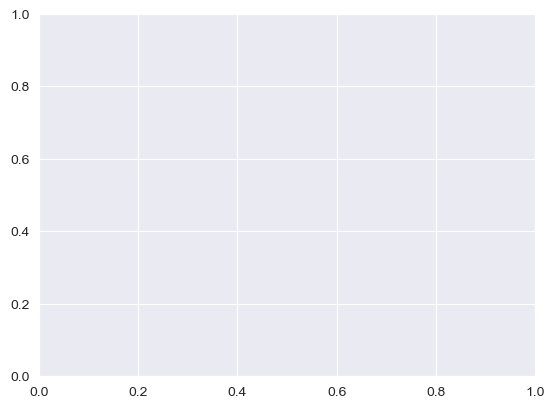

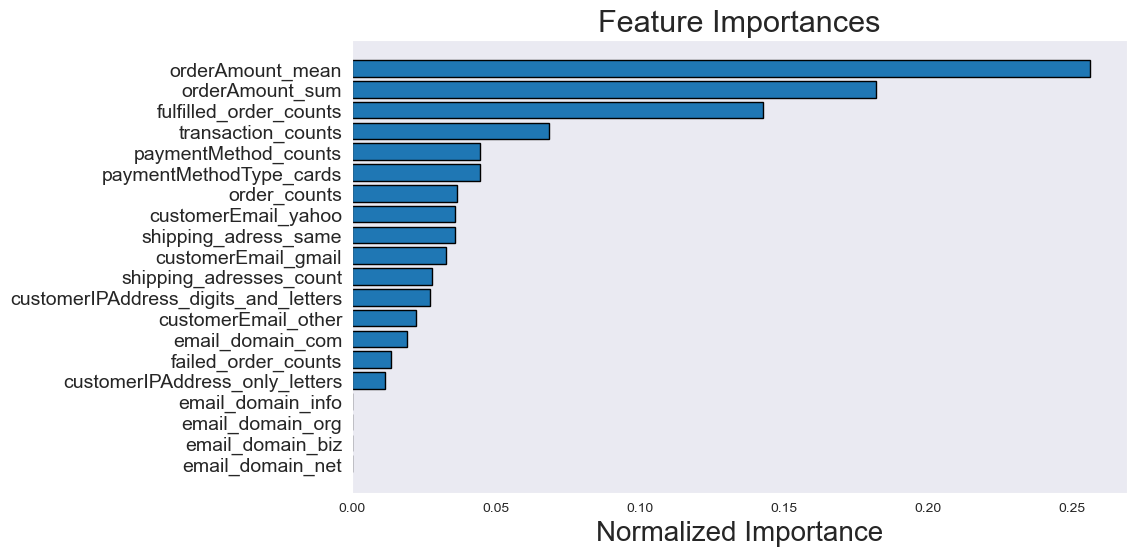

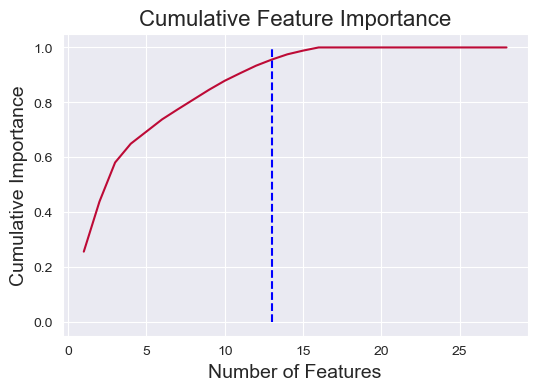

13 features required for 0.95 of cumulative importance
12 features required for cumulative importance of 0.95 after one hot encoding.
16 features do not contribute to cumulative importance of 0.95.



In [84]:
#Optional Feature Selection
from feature_selector import FeatureSelector

fs = FeatureSelector(data = X_train, labels = y_train)
fs.identify_collinear(correlation_threshold = 0.9)
collinear_features = fs.ops['collinear']

# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification',
                            eval_metric = 'binary_logloss',
                            n_iterations = 10,
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

# plot the feature importances
fs.plot_feature_importances(threshold = 0.95, plot_n = 20)

fs.identify_low_importance(cumulative_importance = 0.95)

# Remove the features from all methods (returns a df)
#train_removed = fs.remove(methods = 'all')
#train_removed, X_test = train_removed.align(X_test, axis=1, join='inner')

In [94]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
model = BaggingClassifier(RandomForestClassifier(n_estimators=100, n_jobs=-1))

model.fit(X_train,y_train)

model.score(X_test,y_test) 

0.7352941176470589

In [89]:
svc_model = SVC()

svc_model.fit(X_train,y_train)

svc_model.score(X_test,y_test) 

0.7941176470588235

AUC: 0.708


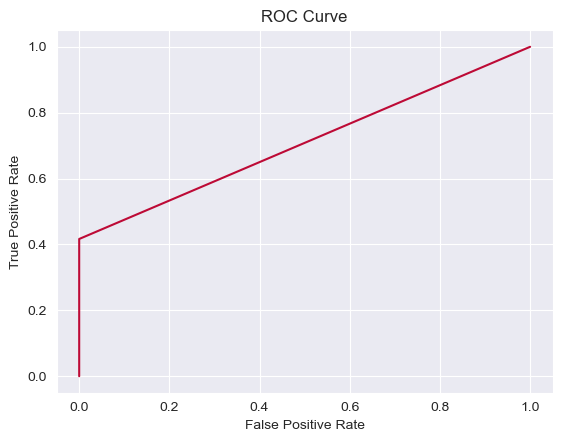

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
##Roc Analization
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred = svc_model.predict(X_test)
fpr,tpr,threshold=roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)
sns.set_style("dark")
plt.grid(True)
plt.plot(fpr, tpr,color='#bd0a36')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [95]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[22  0]
 [ 7  5]]


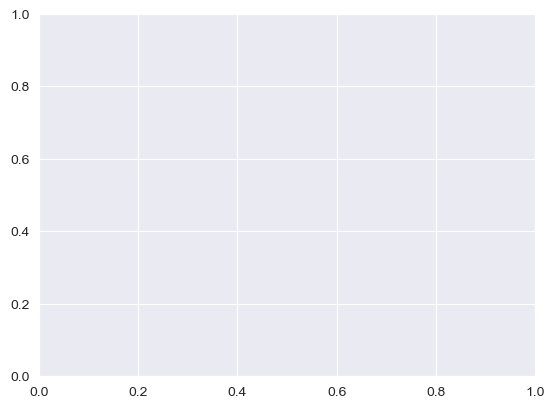

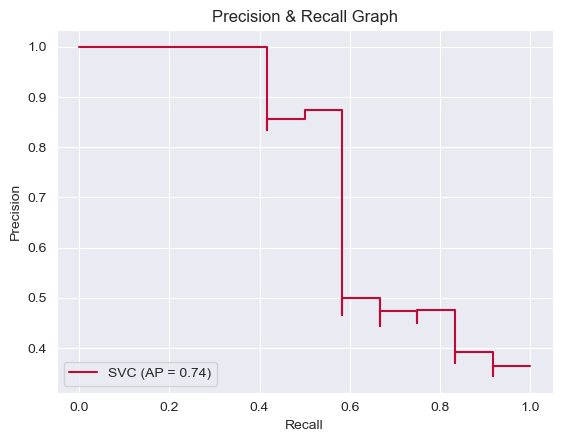

In [100]:
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svc_model, X_test, y_test)

In [101]:
df['fraudulent'].value_counts()

False    107
True      61
Name: fraudulent, dtype: int64